In [1]:
import sys
from pathlib import Path
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
import hsfs

/Users/robert/Documents/Skola/ID2223/Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

HW_API_KEY = os.getenv("HOPSWORKS_API_KEY")
HW_PROJECT = os.getenv("HOPSWORKS_PROJECT")

if not HW_API_KEY or not HW_PROJECT:
    raise ValueError("Missing credentials in .env file")

# Locations to fetch weather data for
with open("locations.json") as f:
    locations = json.load(f)

# Connect to Hopsworks Feature Store
project = hopsworks.login(
    project=HW_PROJECT,
    api_key_value=HW_API_KEY,
    host="eu-west.cloud.hopsworks.ai",
)
fs = project.get_feature_store()

2026-01-11 21:16:01,119 INFO: Initializing external client
2026-01-11 21:16:01,119 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-11 21:16:02,113 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/2186


In [3]:
# Retrieve feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_hourly',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [4]:
# Build feature query
selected_features = (
    electricity_fg
      .select(["date", "price_area", "weather_key", "sek_per_kwh", "exr", "resolution_minutes", "n_intervals"])
      .filter((electricity_fg.price_area == "SE3") & (electricity_fg.weather_key == "se3_set_v1"))
      .join(
          weather_fg.select_features()
                    .filter(weather_fg.weather_key == "se3_set_v1"),
          on=["weather_key"]   # <-- PK only (event_time handled automatically)
      )
)

# Create feature view
feature_view = fs.get_or_create_feature_view(
    name="electricity_se3_hourly_weather_wide_fv",
    version=1,
    description="SE3 hourly electricity price (aggregated) with wide hourly weather features (7 cities).",
    labels=["sek_per_kwh"],
    query=selected_features,
)


2026-01-11 21:16:05,590 INFO: Using ['temperature_2m_stockholm', 'precipitation_stockholm', 'cloud_cover_stockholm', 'wind_speed_10m_stockholm', 'temperature_2m_uppsala', 'precipitation_uppsala', 'cloud_cover_uppsala', 'wind_speed_10m_uppsala', 'temperature_2m_vasteras', 'precipitation_vasteras', 'cloud_cover_vasteras', 'wind_speed_10m_vasteras', 'temperature_2m_orebro', 'precipitation_orebro', 'cloud_cover_orebro', 'wind_speed_10m_orebro', 'temperature_2m_karlstad', 'precipitation_karlstad', 'cloud_cover_karlstad', 'wind_speed_10m_karlstad', 'temperature_2m_sundsvall', 'precipitation_sundsvall', 'cloud_cover_sundsvall', 'wind_speed_10m_sundsvall', 'temperature_2m_malmo', 'precipitation_malmo', 'cloud_cover_malmo', 'wind_speed_10m_malmo'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [5]:
start_date_test_data = "2025-06-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.21s) 
2026-01-11 21:16:17,266 INFO: Computing insert statistics
2026-01-11 21:16:17,307 INFO: Computing insert statistics


In [7]:
X_train

,date,price_area,weather_key,exr,resolution_minutes,n_intervals,temperature_2m_stockholm,precipitation_stockholm,cloud_cover_stockholm,wind_speed_10m_stockholm,...,cloud_cover_karlstad,wind_speed_10m_karlstad,temperature_2m_sundsvall,precipitation_sundsvall,cloud_cover_sundsvall,wind_speed_10m_sundsvall,temperature_2m_malmo,precipitation_malmo,cloud_cover_malmo,wind_speed_10m_malmo
0,2021-11-01 00:00:00,SE3,se3_set_v1,9.883080,60,1,6.65,0.0,100.0,11.874544,...,100.0,21.578989,2.50,0.0,100.0,6.763786,13.841499,0.0,100.0,32.217484
1,2021-11-01 01:00:00,SE3,se3_set_v1,9.883080,60,1,7.55,0.0,100.0,10.805998,...,100.0,24.363251,1.80,0.0,100.0,6.830519,14.291500,0.0,100.0,34.388950
2,2021-11-01 02:00:00,SE3,se3_set_v1,9.883080,60,1,8.50,0.0,100.0,11.384198,...,100.0,27.698952,1.70,0.0,100.0,5.351785,13.591499,0.0,100.0,29.555099
3,2021-11-01 03:00:00,SE3,se3_set_v1,9.883080,60,1,8.65,0.0,100.0,13.392774,...,100.0,33.291729,0.95,0.0,100.0,2.902413,13.041500,0.0,100.0,23.039999
4,2021-11-01 04:00:00,SE3,se3_set_v1,9.883080,60,1,9.05,0.0,100.0,15.778516,...,100.0,31.353085,1.95,0.0,100.0,1.835647,12.041500,0.0,100.0,21.575987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31386,2025-05-31 19:00:00,SE3,se3_set_v1,10.870351,60,1,15.70,0.0,29.0,5.351785,...,4.0,10.234705,11.55,0.0,0.0,14.110209,14.991500,0.0,0.0,5.495161
31387,2025-05-31 20:00:00,SE3,se3_set_v1,10.870351,60,1,13.95,0.0,0.0,4.889908,...,0.0,6.681856,10.15,0.0,0.0,13.379461,14.291500,0.0,0.0,9.919618
31388,2025-05-31 21:00:00,SE3,se3_set_v1,10.870351,60,1,12.65,0.0,21.0,3.758510,...,0.0,4.669604,9.05,0.0,0.0,13.213764,13.891500,0.0,0.0,10.365251
31389,2025-05-31 22:00:00,SE3,se3_set_v1,10.883924,60,1,12.35,0.0,0.0,0.254558,...,0.0,8.557102,8.20,0.0,0.0,12.962500,13.241500,0.0,0.0,11.398420


In [8]:
X_features = X_train.drop(columns=["date", "price_area", "weather_key", "exr", "resolution_minutes", "n_intervals"])
X_test_features = X_test.drop(columns=['date', "price_area", "weather_key", "exr", "resolution_minutes", "n_intervals"])

In [9]:
X_features

,temperature_2m_stockholm,precipitation_stockholm,cloud_cover_stockholm,wind_speed_10m_stockholm,temperature_2m_uppsala,precipitation_uppsala,cloud_cover_uppsala,wind_speed_10m_uppsala,temperature_2m_vasteras,precipitation_vasteras,...,cloud_cover_karlstad,wind_speed_10m_karlstad,temperature_2m_sundsvall,precipitation_sundsvall,cloud_cover_sundsvall,wind_speed_10m_sundsvall,temperature_2m_malmo,precipitation_malmo,cloud_cover_malmo,wind_speed_10m_malmo
0,6.65,0.0,100.0,11.874544,5.75,0.0,100.0,8.587338,5.50,0.0,...,100.0,21.578989,2.50,0.0,100.0,6.763786,13.841499,0.0,100.0,32.217484
1,7.55,0.0,100.0,10.805998,5.80,0.0,100.0,10.514218,6.15,0.0,...,100.0,24.363251,1.80,0.0,100.0,6.830519,14.291500,0.0,100.0,34.388950
2,8.50,0.0,100.0,11.384198,5.95,0.0,100.0,11.090103,6.60,0.0,...,100.0,27.698952,1.70,0.0,100.0,5.351785,13.591499,0.0,100.0,29.555099
3,8.65,0.0,100.0,13.392774,6.95,0.0,100.0,11.753876,7.35,0.0,...,100.0,33.291729,0.95,0.0,100.0,2.902413,13.041500,0.0,100.0,23.039999
4,9.05,0.0,100.0,15.778516,7.75,0.0,100.0,14.843180,8.25,0.1,...,100.0,31.353085,1.95,0.0,100.0,1.835647,12.041500,0.0,100.0,21.575987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31386,15.70,0.0,29.0,5.351785,12.50,0.0,0.0,5.509882,14.30,0.0,...,4.0,10.234705,11.55,0.0,0.0,14.110209,14.991500,0.0,0.0,5.495161
31387,13.95,0.0,0.0,4.889908,10.60,0.0,0.0,5.247857,13.05,0.0,...,0.0,6.681856,10.15,0.0,0.0,13.379461,14.291500,0.0,0.0,9.919618
31388,12.65,0.0,21.0,3.758510,9.80,0.0,0.0,3.710795,10.90,0.0,...,0.0,4.669604,9.05,0.0,0.0,13.213764,13.891500,0.0,0.0,10.365251
31389,12.35,0.0,0.0,0.254558,8.75,0.0,0.0,4.557236,9.15,0.0,...,0.0,8.557102,8.20,0.0,0.0,12.962500,13.241500,0.0,0.0,11.398420


In [10]:
y_train = y_train.loc[X_features.index]
y_test = y_test.loc[X_test_features.index]

# Model creation

In [11]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [12]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 0.38219120578077287
R squared: -0.8082382835023565


In [13]:
df = y_test
df['predicted_price'] = y_pred

In [14]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,sek_per_kwh,predicted_price,date
31391,0.37430,0.938100,2025-06-01 00:00:00
31392,0.38453,0.599879,2025-06-01 01:00:00
31393,0.34284,0.852213,2025-06-01 02:00:00
31394,0.29539,0.696727,2025-06-01 03:00:00
31395,0.19482,1.273196,2025-06-01 04:00:00


In [15]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "electricity_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

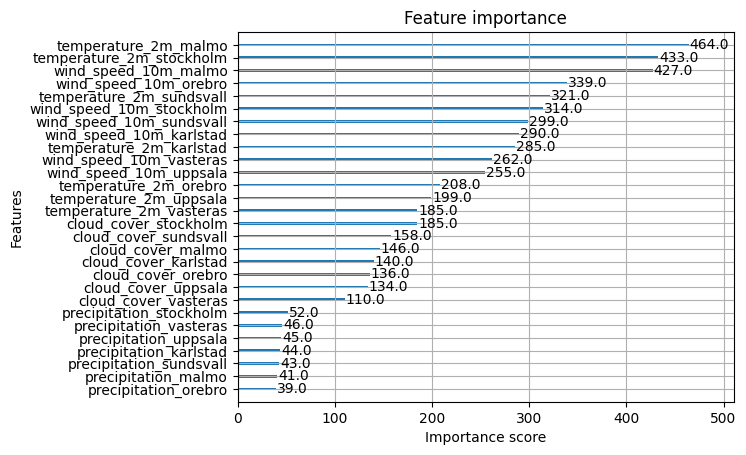

In [16]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + f"/feature_importance_electricity_price.png"
plt.savefig(feature_importance_path)
plt.show()

# Model registry

In [17]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + f"/model_electricity_price.json")

In [18]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [19]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'electricity_price_xgboost_model_se3'

electricity_model = mr.python.create_model(
    name=f"electricity_price_xgboost_model_se3", 
    metrics=res_dict,
    feature_view=feature_view,
    description="Electricity Price predictor for SE3 area using XGBoost",
)

# Saving the model artifacts to the 'electricity_price_model' directory in the model registry
electricity_model.save(model_dir)

ModelRegistryException: No Models dataset exists in project ID2223, Please enable the Serving service or create the dataset manually.